# TODO
1. масштаб графиков и подписей
2. выбросы
3. зависимость от length и width одинакова в случае error_stability
4. сделать больше попыток для каждой конфигурации
5. Анализ метрики, если по ней делался отбор лучшего решения?

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [3]:
pd.options.display.float_format = '{:.7f}'.format

### Характеристики оборудования:

Операционная система:

In [47]:
!cat /etc/os-release

NAME="Ubuntu"
VERSION="21.04 (Hirsute Hippo)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 21.04"
VERSION_ID="21.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=hirsute
UBUNTU_CODENAME=hirsute


CPU:

In [48]:
!lscpu | grep 'Model name'
!lscpu | grep 'Socket(s)'
!lscpu | grep 'Core(s) per socket:'
!lscpu | grep 'Thread(s) per core'
!lscpu | grep "MHz"

Model name:                      Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz
Socket(s):                       1
Core(s) per socket:              4
Thread(s) per core:              2
CPU MHz:                         711.746
CPU max MHz:                     3900,0000
CPU min MHz:                     400,0000


RAM:

In [52]:
!grep MemTotal /proc/meminfo

MemTotal:        8026900 kB


## Testing minimal solvers

In [103]:
esimators = {"median": np.median, "mean": np.mean}

In [106]:
def plot_estimators(x: str, y: str, xlabel: str, ylabel: str, hue: str, data: pd.DataFrame, title: str):
    fig, axes = plt.subplots(ncols=2, figsize=(18, 9))
    fig.subplots_adjust(left=0.05, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
    fig.suptitle(title, fontsize=18)

    for i, (est_name, est) in enumerate(esimators.items()):
        sns.lineplot(
            ax=axes[i],
            x=x, 
            y=y, 
            hue=hue, 
            estimator=est,
            data=data
        )
        axes[i].set(ylabel=f"{ylabel} ({est_name})", xlabel=xlabel)

In [ ]:
motion_df = pd.read_csv("./error_motion.csv")
stability_df = pd.read_csv("./error_stability.csv")

### Характеристики датасетов:

In [69]:
motion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   method_name     35000 non-null  object 
 1   motion_length   35000 non-null  float64
 2   turning_angle   35000 non-null  float64
 3   experiment_num  35000 non-null  int64  
 4   ATE             35000 non-null  float64
 5   RTE             35000 non-null  float64
 6   ARE             35000 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 1.9+ MB


In [70]:
stability_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   method_name     35000 non-null  object 
 1   scene_width     35000 non-null  float64
 2   scene_length    35000 non-null  float64
 3   angle_std       35000 non-null  float64
 4   experiment_num  35000 non-null  int64  
 5   ATE             35000 non-null  float64
 6   RTE             35000 non-null  float64
 7   ARE             35000 non-null  float64
 8   time            35000 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 2.4+ MB


### Основные статистики запросов:

In [67]:
motion_inf_mask = motion_df["ATE"].isin([np.inf, -np.inf])
motion_df[~motion_inf_mask].groupby(["method_name"])[["ARE", "ATE", "RTE"]].describe().T

method_name         17pt                    6pt  6pt_opengv_raw  6pt_poselib  \
ARE count   5000.0000000           5000.0000000    5000.0000000 4629.0000000   
    mean       0.0000000              0.6002797       2.9731324    0.0000151   
    std        0.0000000              0.7433841       0.1724724    0.0006242   
    min        0.0000000              0.0000000       0.6636570    0.0000000   
    25%        0.0000000              0.1774918       2.8965975    0.0000000   
    50%        0.0000000              0.3716520       3.0162300    0.0000000   
    75%        0.0000000              0.6491515       3.0953750    0.0000000   
    max        0.0000000              3.1415900       3.1415900    0.0314499   
ATE count   5000.0000000           5000.0000000    5000.0000000 4629.0000000   
    mean       1.1516280     4582492347.4549761      11.4999940    0.3565980   
    std        3.8566165   200504171366.1382446       5.4259558    2.2548299   
    min        0.0000000              0.0000000       3.0000000    0.0000000   
    25%        0.0000000             10.5678000       6.7777800    0.0000000   
    50%        0.0000000             16.2963000      11.5000000    0.0000000   
    75%        0.0000000             22.0864250      16.2222000    0.0000000   
    max       21.4093000 13734400000000.0000000      20.0000000   19.9991000   
RTE count   5000.0000000           5000.0000000    5000.0000000 4629.0000000   
    mean       0.1564517              1.3121535       1.5708000    0.0007252   
    std        0.4704481              0.3589148       0.0000000    0.0327994   
    min        0.0000000              0.0000000       1.5708000    0.0000000   
    25%        0.0000000              1.1755125       1.5708000    0.0000000   
    50%        0.0000000              1.4726450       1.5708000    0.0000000   
    75%        0.0000000              1.5708000       1.5708000    0.0000000   
    max        1.5708000              1.5708000       1.5708000    1.5708000   

method_name          8pt    8pt_colmap          c+s  
ARE count   5000.0000000  4998.0000000 5000.0000000  
    mean       0.1085902     0.1357077    0.0488727  
    std        0.1952156     0.2575447    0.2425466  
    min        0.0000003     0.0000003    0.0000000  
    25%        0.0000441     0.0000451    0.0000000  
    50%        0.0071471     0.0065620    0.0000000  
    75%        0.1475462     0.1672165    0.0000000  
    max        1.7226600     2.8053500    3.0099500  
ATE count   5000.0000000  4998.0000000 5000.0000000  
    mean      12.7319729    47.0061979    1.2962496  
    std      109.1723241  1301.9577644    5.6658453  
    min        0.0000049     0.0000216    0.0000000  
    25%        0.0133623     0.0127274    0.0000000  
    50%        3.3275150     2.9915700    0.0000000  
    75%       13.2181000    11.6789500    0.0000000  
    max     6706.1100000 74492.0000000  196.1700000  
RTE count   5000.0000000  4998.0000000 5000.0000000  
    mean       0.6709459     0.2317096    0.0936473  
    std        0.7561825     0.3610413    0.3642763  
    min        0.0000002     0.0000002    0.0000000  
    25%        0.0000549     0.0000541    0.0000000  
    50%        0.0354250     0.0097318    0.0000000  
    75%        1.5708000     0.3822622    0.0000000  
    max        1.5708000     1.5627800    1.5708000

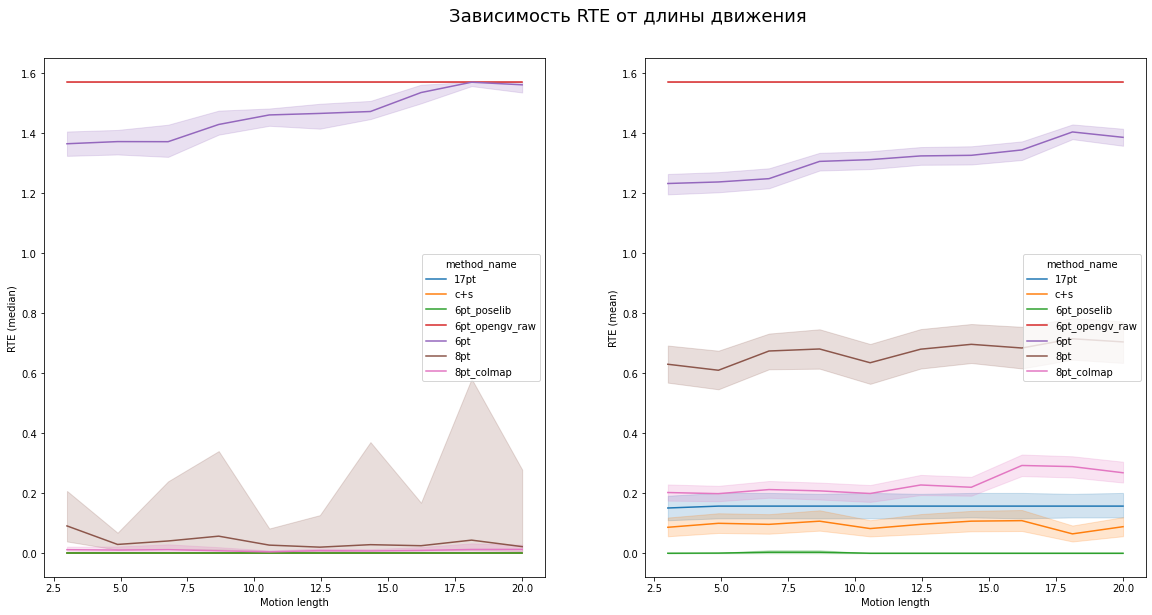

In [113]:
plot_estimators(
    x="motion_length", 
    y="RTE", 
    xlabel="Motion length", 
    ylabel="RTE", 
    hue="method_name", 
    data=motion_df, 
    title="Зависимость RTE от длины движения"
)

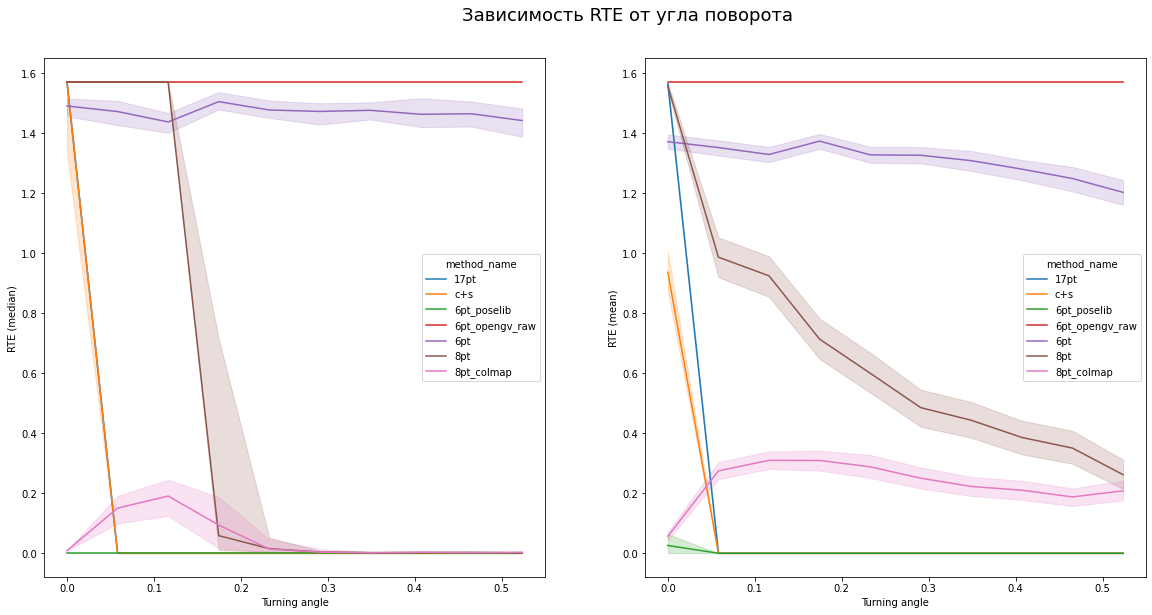

In [112]:
plot_estimators(
    x="turning_angle", 
    y="RTE", 
    xlabel="Turning angle", 
    ylabel="RTE", 
    hue="method_name", 
    data=motion_df, 
    title="Зависимость RTE от угла поворота"
)

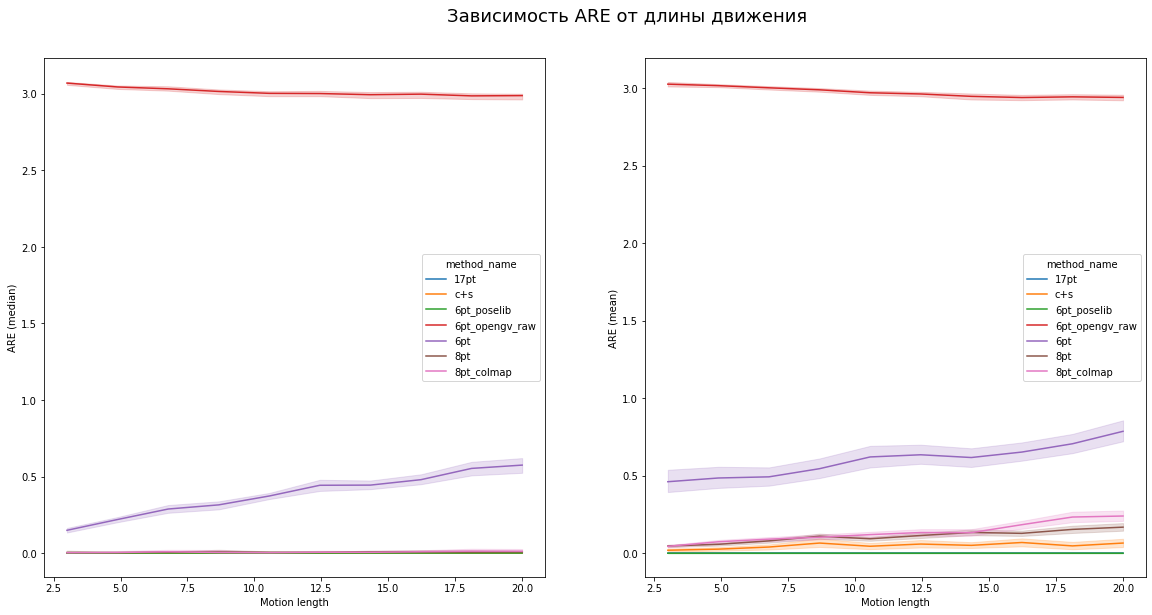

In [111]:
plot_estimators(
    x="motion_length", 
    y="ARE", 
    xlabel="Motion length", 
    ylabel="ARE", 
    hue="method_name", 
    data=motion_df, 
    title="Зависимость ARE от длины движения"
)

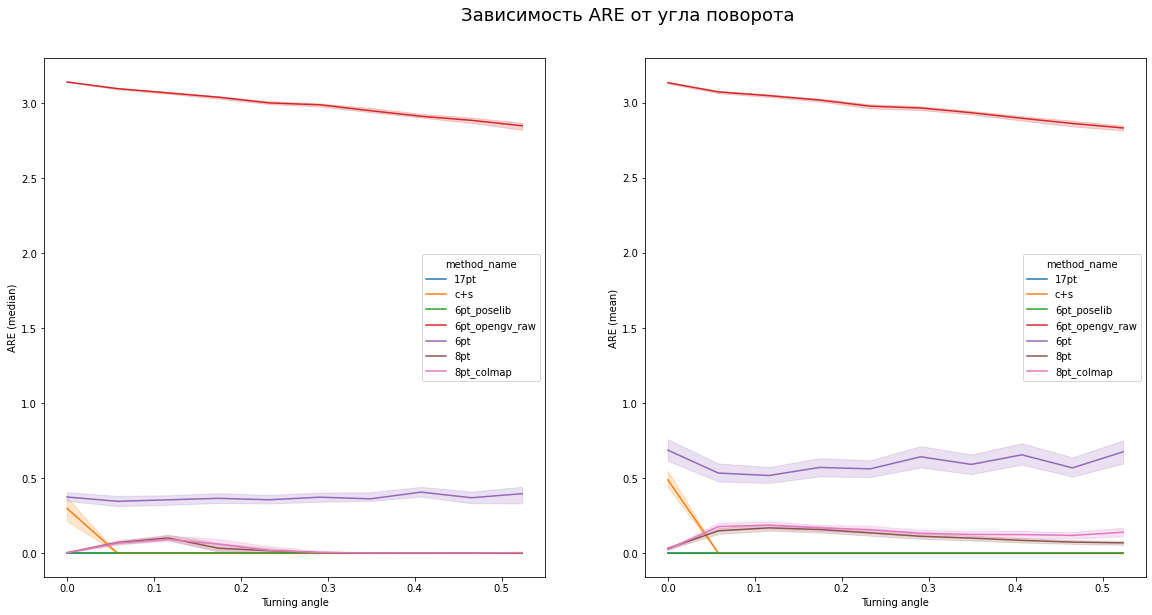

In [110]:
plot_estimators(
    x="turning_angle", 
    y="ARE", 
    xlabel="Turning angle", 
    ylabel="ARE", 
    hue="method_name", 
    data=motion_df, 
    title="Зависимость ARE от угла поворота"
)

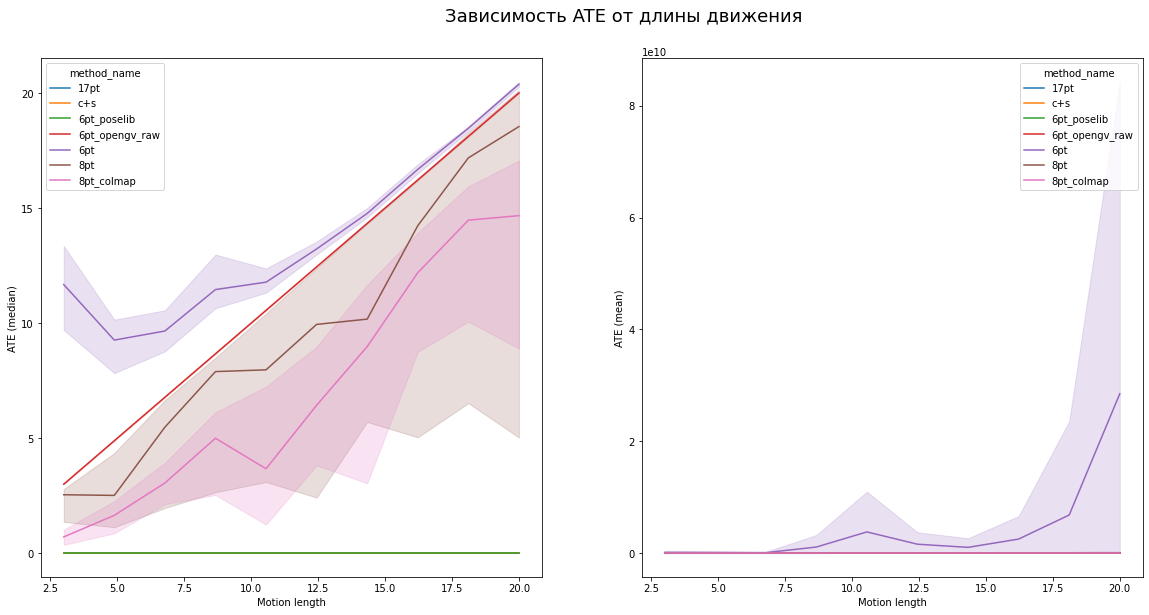

In [109]:
plot_estimators(
    x="motion_length", 
    y="ATE", 
    xlabel="Motion length", 
    ylabel="ATE", 
    hue="method_name", 
    data=motion_df, 
    title="Зависимость ATE от длины движения"
)

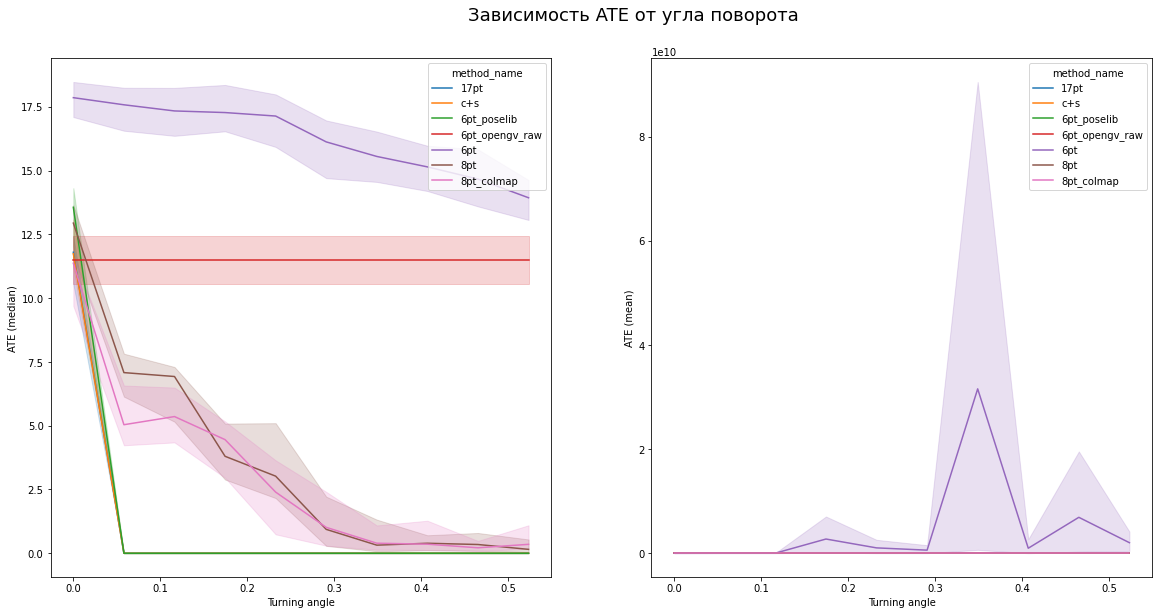

In [108]:
plot_estimators(
    x="turning_angle", 
    y="ATE", 
    xlabel="Turning angle", 
    ylabel="ATE", 
    hue="method_name", 
    data=motion_df, 
    title="Зависимость ATE от угла поворота"
)

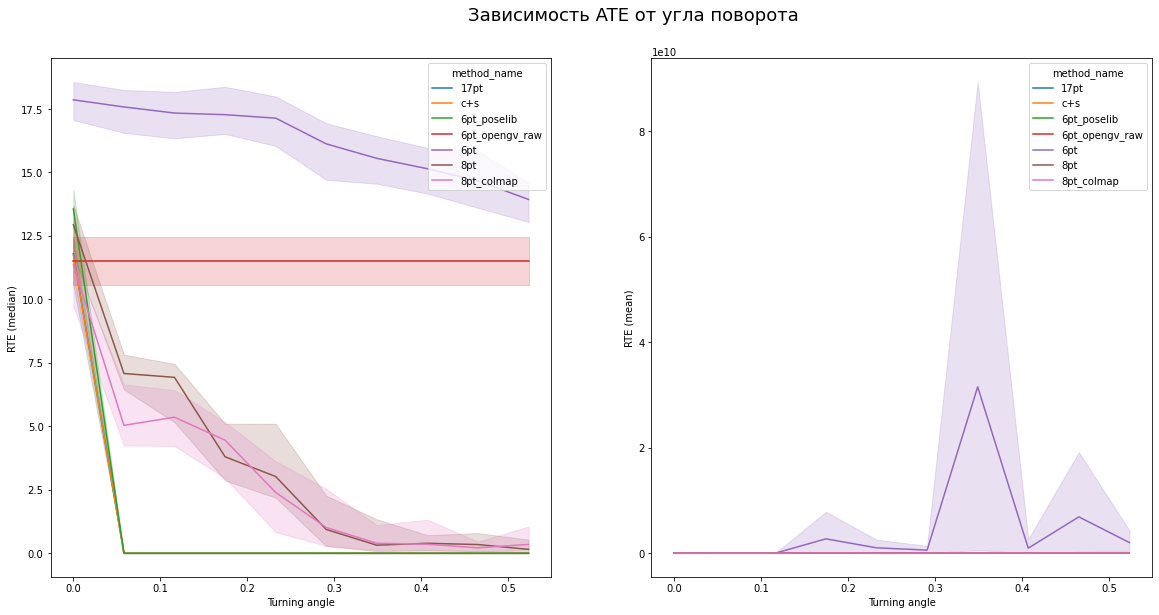

In [114]:
plot_estimators(
    x="turning_angle", 
    y="ATE", 
    xlabel="Turning angle", 
    ylabel="RTE", 
    hue="method_name", 
    data=motion_df, 
    title="Зависимость ATE от угла поворота"
)

In [72]:
stability_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   method_name     35000 non-null  object 
 1   scene_width     35000 non-null  float64
 2   scene_length    35000 non-null  float64
 3   angle_std       35000 non-null  float64
 4   experiment_num  35000 non-null  int64  
 5   ATE             35000 non-null  float64
 6   RTE             35000 non-null  float64
 7   ARE             35000 non-null  float64
 8   time            35000 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 2.4+ MB


In [71]:
st_inf_mask = stability_df["ATE"].isin([np.inf, -np.inf])
stability_df[~st_inf_mask].groupby(["method_name"])[["ARE", "ATE", "RTE", "time"]].describe().T

method_name         17pt                   6pt  6pt_opengv_raw  6pt_poselib  \
ARE  count  5000.0000000          5000.0000000    5000.0000000 4675.0000000   
     mean      0.0267567             0.3984657       2.5389678    0.0154956   
     std       0.0844736             0.6460431       0.4282395    0.0616044   
     min       0.0000000             0.0000000       0.2051820    0.0000000   
     25%       0.0046339             0.0829961       2.2504350    0.0016474   
     50%       0.0121896             0.2016405       2.6071150    0.0049156   
     75%       0.0274614             0.3942542       2.8986100    0.0116467   
     max       3.0752800             3.1412400       3.1411500    1.3748100   
ATE  count  5000.0000000          5000.0000000    5000.0000000 4675.0000000   
     mean      0.7079480     893365349.8889751       5.0000000    0.8132668   
     std       1.0837753   57262332954.6335526       0.0000000   10.0455907   
     min       0.0000000             0.0000000       5.0000000    0.0000000   
     25%       0.0961237             4.6522225       5.0000000    0.0502718   
     50%       0.3099825             5.2000800       5.0000000    0.1684440   
     75%       0.7766935             5.7573150       5.0000000    0.4977740   
     max      10.8758000 4041000000000.0000000       5.0000000  455.8680000   
RTE  count  5000.0000000          5000.0000000    5000.0000000 4675.0000000   
     mean      0.1015143             1.2114790       1.5708000    0.0459722   
     std       0.2344048             0.4863120       0.0000000    0.1219938   
     min       0.0000000             0.0000000       1.5708000    0.0000000   
     25%       0.0084833             0.9929297       1.5708000    0.0045719   
     50%       0.0285221             1.4619150       1.5708000    0.0146755   
     75%       0.0832822             1.5708000       1.5708000    0.0379100   
     max       1.5708000             1.5708000       1.5708000    1.5708000   
time count  5000.0000000          5000.0000000    5000.0000000 4675.0000000   
     mean      0.0000492             0.0015330       0.0013942    0.0009622   
     std       0.0000086             0.0000926       0.0000876    0.0000703   
     min       0.0000411             0.0013038       0.0011653    0.0007639   
     25%       0.0000462             0.0014711       0.0013388    0.0009159   
     50%       0.0000473             0.0015223       0.0013850    0.0009543   
     75%       0.0000485             0.0015806       0.0014377    0.0009987   
     max       0.0001321             0.0022738       0.0024276    0.0014571   

method_name           8pt     8pt_colmap           c+s  
ARE  count   5000.0000000   5000.0000000  5000.0000000  
     mean       0.0367781      1.0069224     0.0381472  
     std        0.0692181      1.2932700     0.0879039  
     min        0.0000005      0.0000001     0.0000000  
     25%        0.0018290      0.0115134     0.0066218  
     50%        0.0053139      0.2339610     0.0185610  
     75%        0.0444144      2.8803175     0.0435727  
     max        0.6597440      3.1415800     2.2924900  
ATE  count   5000.0000000   5000.0000000  5000.0000000  
     mean       9.6983978     77.9186688     8.7306069  
     std      273.3798620   1895.5013926   248.6401612  
     min        0.0000146      0.0000010     0.0000000  
     25%        0.0538353      0.4139445     0.2392860  
     50%        0.1802205      4.3883050     1.0044450  
     75%        2.0810625      7.8200450     3.3668250  
     max    18922.1000000 113683.0000000 17219.4000000  
RTE  count   5000.0000000   5000.0000000  5000.0000000  
     mean       0.2181874      0.4957295     0.3253194  
     std        0.4346821      0.4572662     0.4939482  
     min        0.0000002      0.0000002     0.0000000  
     25%        0.0052023      0.0316329     0.0238539  
     50%        0.0177324      0.4044965     0.0941357  
     75%        0.1537767      0.8427780     0.3465342  
     max        1.570800

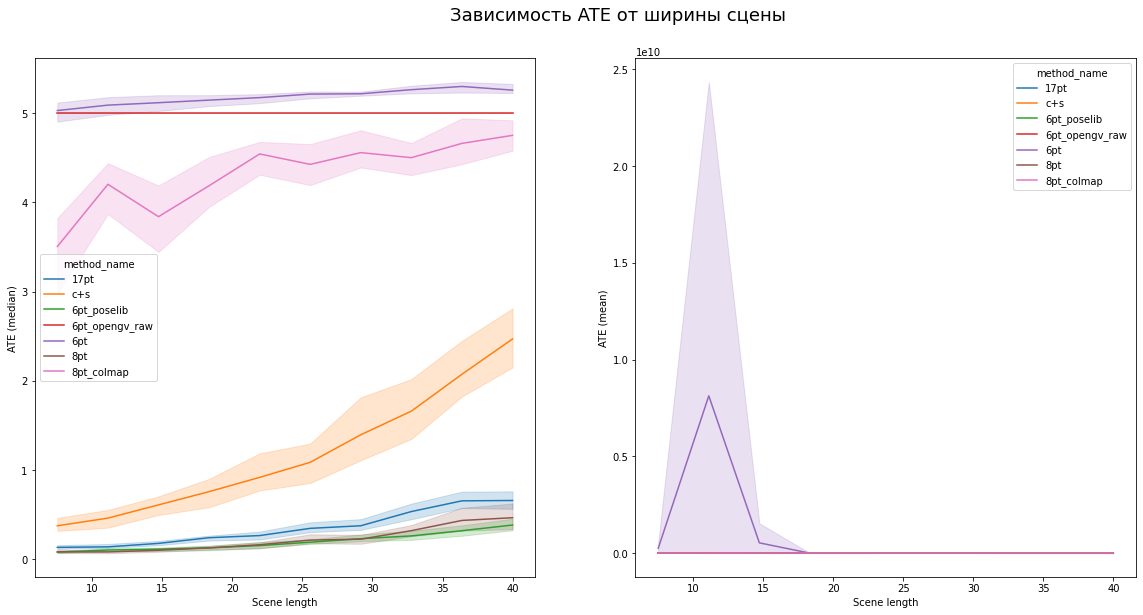

In [115]:
plot_estimators(
    x="scene_length", 
    y="ATE", 
    xlabel="Scene length", 
    ylabel="ATE", 
    hue="method_name", 
    data=stability_df, 
    title="Зависимость ATE от ширины сцены"
)

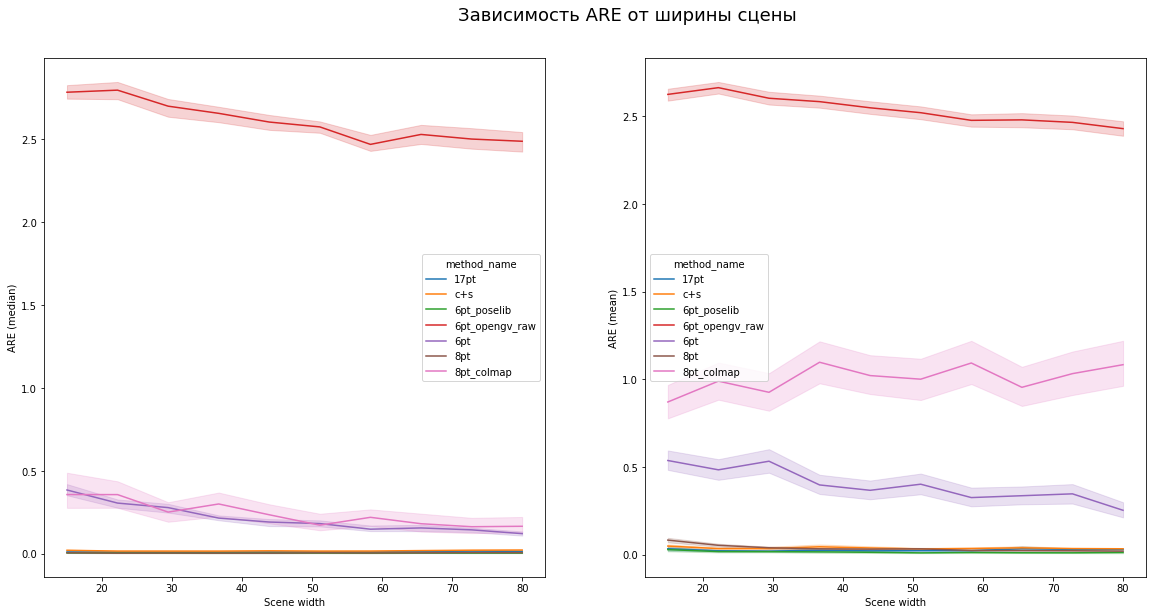

In [117]:
plot_estimators(
    x="scene_width", 
    y="ARE", 
    xlabel="Scene width", 
    ylabel="ARE", 
    hue="method_name", 
    data=stability_df, 
    title="Зависимость ARE от ширины сцены"
)

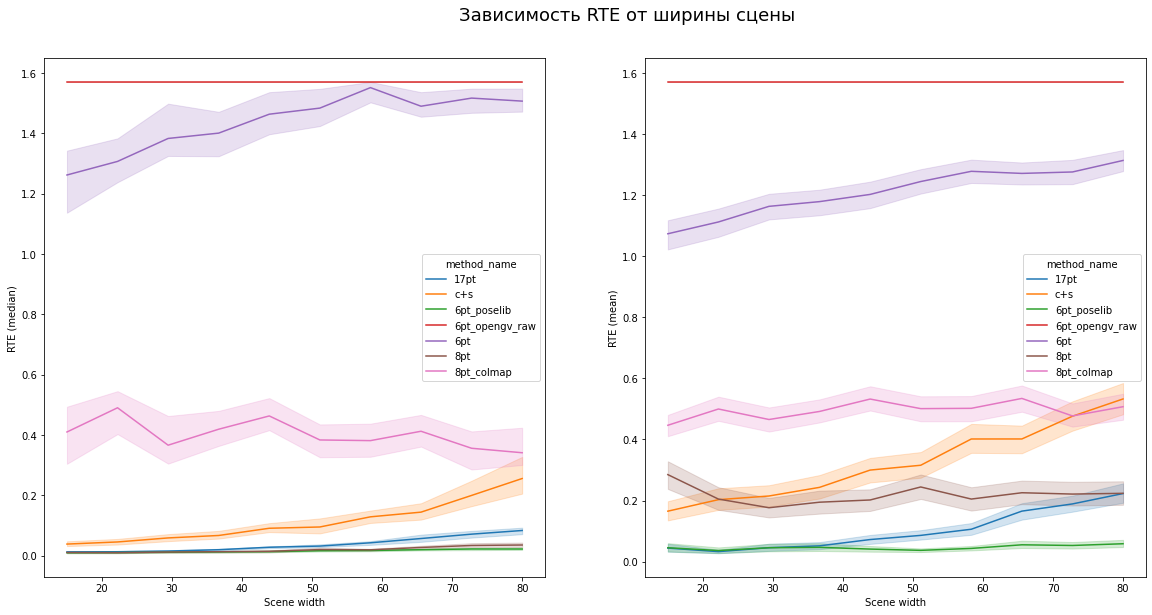

In [118]:
plot_estimators(
    x="scene_width", 
    y="RTE", 
    xlabel="Scene width", 
    ylabel="RTE", 
    hue="method_name", 
    data=stability_df, 
    title="Зависимость RTE от ширины сцены"
)

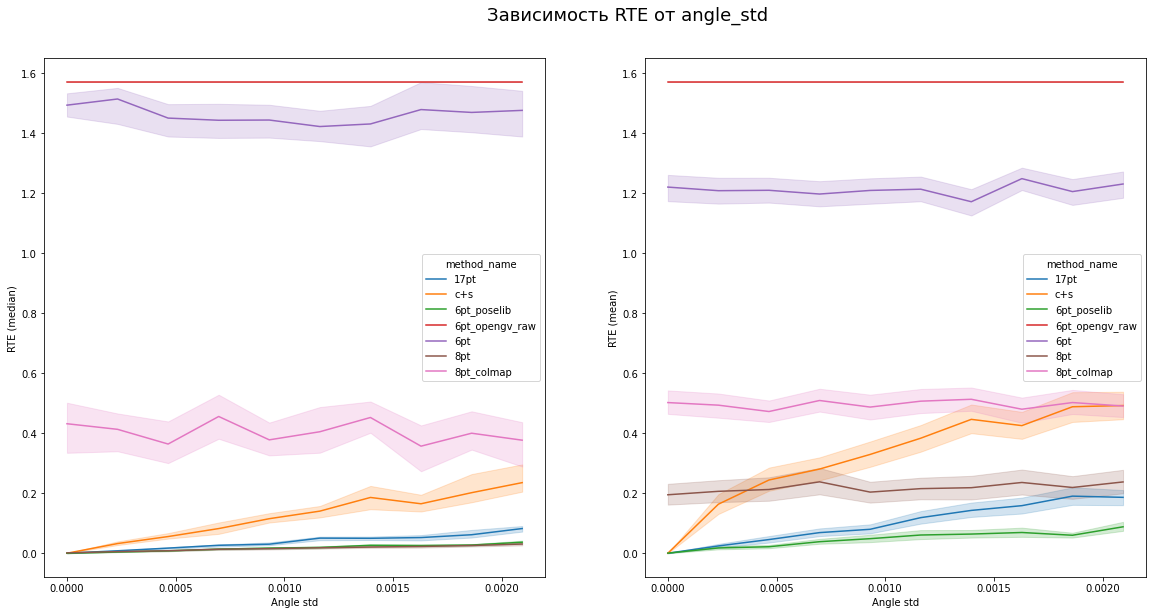

In [119]:
plot_estimators(
    x="angle_std", 
    y="RTE", 
    xlabel="Angle std", 
    ylabel="RTE", 
    hue="method_name", 
    data=stability_df, 
    title="Зависимость RTE от angle_std"
)

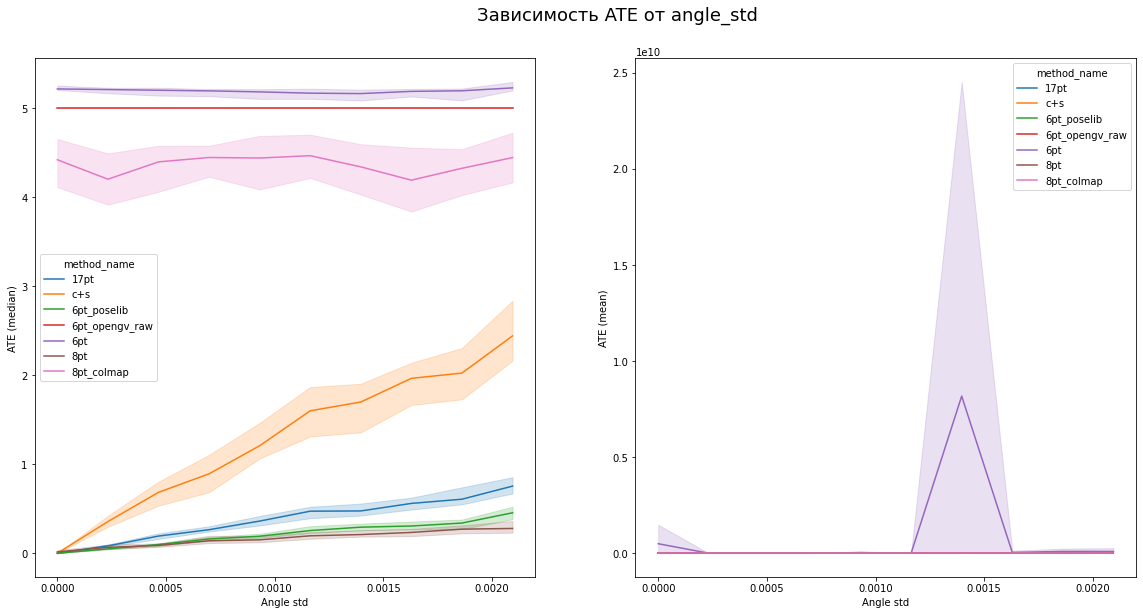

In [120]:
plot_estimators(
    x="angle_std", 
    y="ATE", 
    xlabel="Angle std", 
    ylabel="ATE", 
    hue="method_name", 
    data=stability_df, 
    title="Зависимость ATE от angle_std"
)

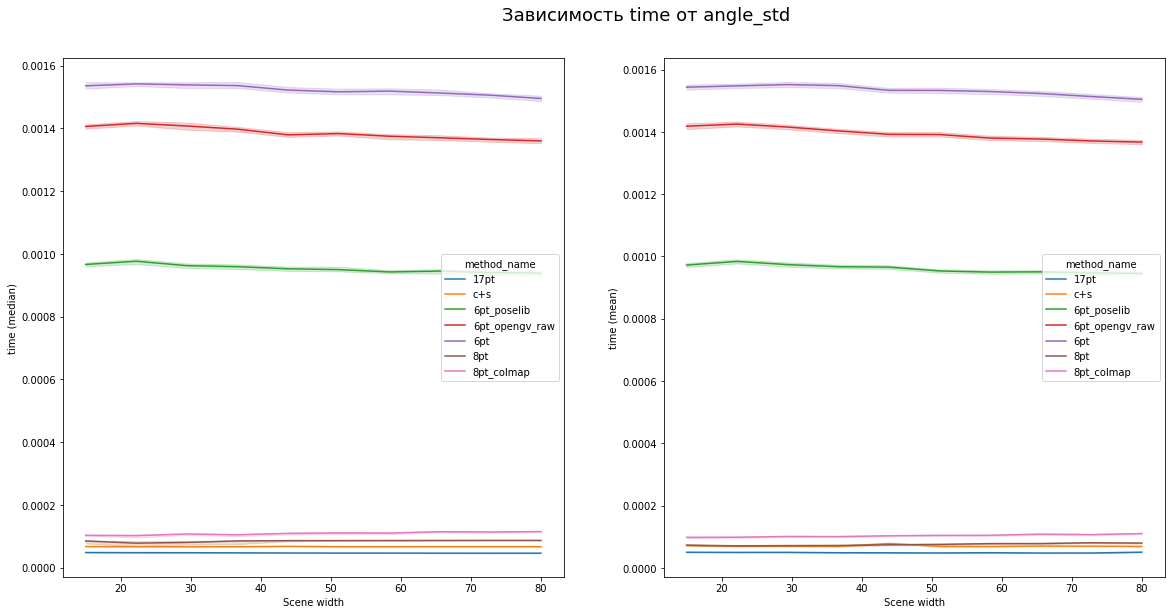

In [121]:
plot_estimators(
    x="scene_width", 
    y="time", 
    xlabel="Scene width", 
    ylabel="time", 
    hue="method_name", 
    data=stability_df, 
    title="Зависимость time от angle_std"
)

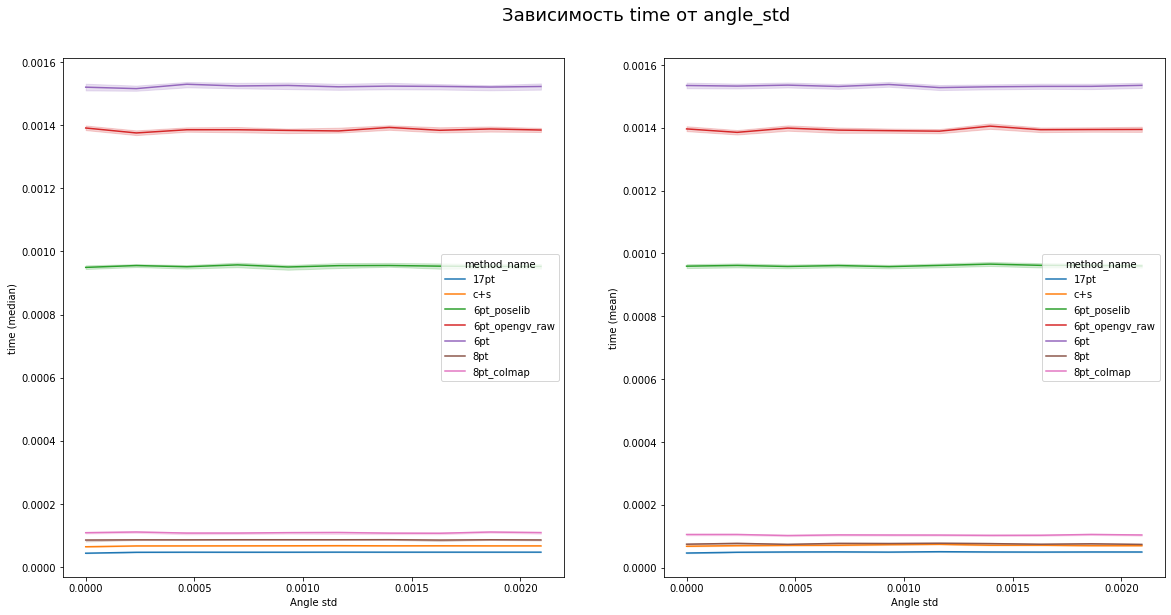

In [122]:
plot_estimators(
    x="angle_std", 
    y="time", 
    xlabel="Angle std", 
    ylabel="time", 
    hue="method_name", 
    data=stability_df, 
    title="Зависимость time от angle_std"
)

In [ ]:
sns.barplot(
            ax=axes[i], 
            x="method_name", 
            y="time", 
            data=stability_df,
            estimator=est
        )
        axes[i].set(ylabel=f"Time(s) ({est_name})", xlabel="Method")

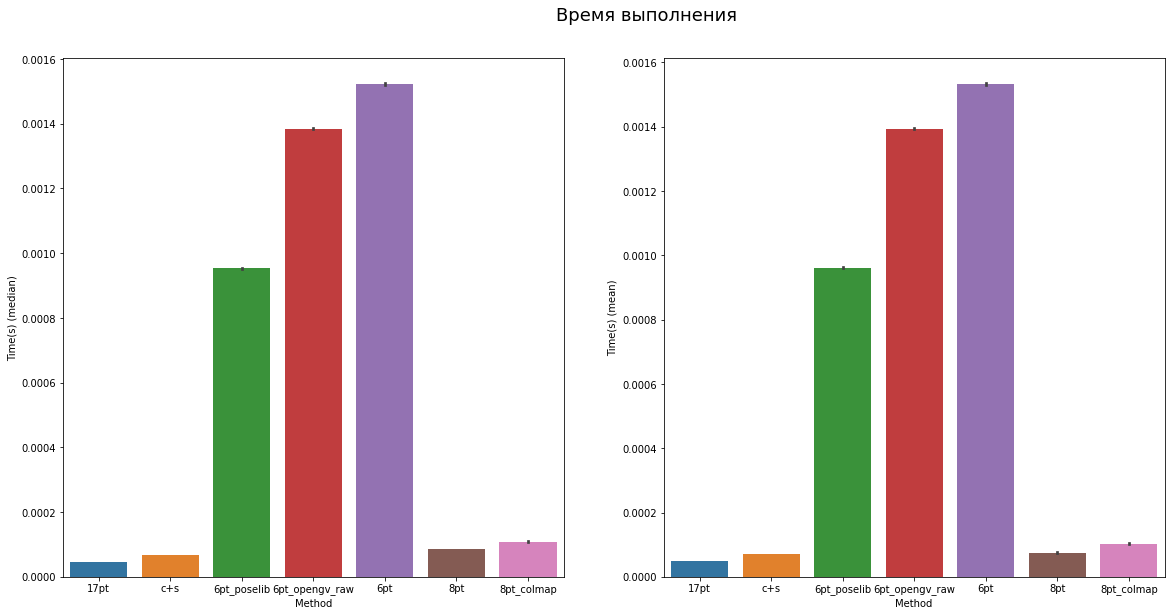

In [131]:
fig, axes = plt.subplots(ncols=2,figsize=(18, 9))
fig.subplots_adjust(left=0.05, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
fig.suptitle('Время выполнения', fontsize=18)

for i, (est_name, est) in enumerate(esimators.items()):        
        sns.barplot(
            ax=axes[i], 
            x="method_name", 
            y="time", 
            data=stability_df,
            estimator=est
        )
        axes[i].set(ylabel=f"Time(s) ({est_name})", xlabel="Method")
